# reel driver classifier analysis

## import dependancies

In [18]:
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns

## import data

In [19]:
media = pl.read_parquet("../data/media.parquet")
results = pl.read_parquet("../data/binomial_classifier_results.parquet")

display(media.head())
display(results.head())

hash,media_type,media_title,season,episode,release_year,pipeline_status,error_status,error_condition,rejection_status,rejection_reason,parent_path,target_path,original_title,original_path,original_link,rss_source,uploader,genre,language,rt_score,metascore,imdb_rating,imdb_votes,imdb_id,resolution,video_codec,upload_type,audio_codec,created_at,updated_at
str,cat,str,i64,i64,i64,cat,bool,str,cat,str,str,str,str,str,str,cat,str,list[str],list[str],i64,i64,f64,i64,str,str,str,str,str,datetime[μs],datetime[μs]
"""7da6924ffc94f55d496b80137346de…","""movie""","""Three Little Words""",null,null,1950,"""rejected""",false,null,"""rejected""","""resolution 720p is not in allo…",null,null,"""Three Little Words (1950) [720…",null,"""https://yts.mx/torrent/downloa…","""yts.mx""","""YTS.MX""","[""Biography"", ""Comedy"", ""Musical""]","[""English""]",null,null,69.0,2091,"""tt0043044""","""720p""",null,null,null,2025-01-10 04:47:04.233518,2025-01-16 17:28:57.023399
"""ff6eb474000b974c651cbbcf7c6797…","""movie""","""The Claim""",null,null,2000,"""rejected""",false,null,"""rejected""","""resolution 720p is not in allo…",null,null,"""The Claim (2000) [720p] [BluRa…",null,"""https://yts.mx/torrent/downloa…","""yts.mx""","""YTS.MX""","[""Drama"", ""Romance"", ""Western""]","[""English""]",62,62,63.0,6680,"""tt0218378""","""720p""",null,null,null,2025-01-08 18:47:03.852864,2025-01-16 17:28:57.023399
"""0cba9e7050741eef2f60a5ced876d2…","""movie""","""Girls' Night Out""",null,null,2023,"""rejected""",false,null,"""rejected""","""rt_score is null""",null,null,"""Girls' Night Out (2023) [1080p…",null,"""https://yts.mx/torrent/downloa…","""yts.mx""","""YTS.MX""","[""Drama""]","[""English""]",null,null,56.0,10,"""tt17736504""","""1080p""",null,null,null,2025-01-10 18:47:03.366807,2025-01-16 17:28:57.023399
"""818eeb51d7db79d8305a365f7b9643…","""movie""","""The Claim""",null,null,2000,"""rejected""",false,null,"""rejected""","""rt_score 62.0 is below min""",null,null,"""The Claim (2000) [1080p] [WEBR…",null,"""https://yts.mx/torrent/downloa…","""yts.mx""","""YTS.MX""","[""Drama"", ""Romance"", ""Western""]","[""English""]",62,62,63.0,6680,"""tt0218378""","""1080p""",null,null,null,2025-01-08 18:47:03.852864,2025-01-16 17:28:57.023399
"""d0f56bea0ebbf7c4b5579a36722e7c…","""movie""","""One Piece Film Z""",null,null,2012,"""rejected""",false,null,"""rejected""","""language ['Japanese'] does not…",null,null,"""One Piece Film Z (2012) [720p]…",null,"""https://yts.mx/torrent/downloa…","""yts.mx""","""YTS.MX""","[""Animation"", ""Action"", ""Adventure""]","[""Japanese""]",null,null,77.0,10157,"""tt2375379""","""720p""",null,null,null,2025-01-06 17:47:03.427029,2025-01-16 17:28:57.023399


actual,predicted,probability,hash
bool,i64,f32,str
false,0,0.006576,"""76baff04b4650308c798979a31e173…"
true,1,0.955362,"""d84a9004990ed9d4f5cfaec733bb2a…"
false,0,0.00333,"""6fe9911e4c0ab85b8503114894bd48…"
false,0,0.002874,"""b58bf9c5877447e58852eef5d713c3…"
false,0,0.064225,"""717593b085cfec7548b0036e1ea90b…"


## format data for analysis

In [20]:
# join tables
df = results.join(media, on="hash", how="left")

# coerce predcited to boolean 
df = df.with_columns(pl.col("predicted").cast(pl.Boolean))

# create all confusion matrix fields
df = df.with_columns(
    cm_value = pl.when(pl.col("actual"))
        .then(
            pl.when(pl.col("predicted"))
                .then(pl.lit("TP"))
                .otherwise(pl.lit("FN"))
        ).otherwise(
            pl.when(pl.col("predicted"))
                .then(pl.lit("FP"))
                .otherwise(pl.lit("TN"))        
        )
)

# select only relevant fields
df = df.select(
    "media_title",
    "predicted",
    "actual",
    "cm_value",
    "probability",
    "release_year",
    "rt_score",
    "metascore",
    "imdb_rating",
    "imdb_votes",
    "original_title",
    "hash"
)

display(df.head())

# convert to pandas for compabiltiy 
pdf = df.to_pandas()

media_title,predicted,actual,cm_value,probability,release_year,rt_score,metascore,imdb_rating,imdb_votes,original_title,hash
str,bool,bool,str,f32,i64,i64,i64,f64,i64,str,str
"""A Danfo Christmas""",false,false,"""TN""",0.006576,2024,null,null,null,null,"""A Danfo Christmas (2024) [720p…","""76baff04b4650308c798979a31e173…"
"""A World Not Ours""",true,true,"""TP""",0.955362,2012,100,65,79.0,597,"""A World Not Ours (2012) [1080p…","""d84a9004990ed9d4f5cfaec733bb2a…"
"""Heist""",false,false,"""TN""",0.00333,2019,null,null,null,16,"""Heist (2019) [1080p] [WEBRip] …","""6fe9911e4c0ab85b8503114894bd48…"
"""12 Dares of Christmas""",false,false,"""TN""",0.002874,2023,null,null,59.0,104,"""12 Dares of Christmas (2023) […","""b58bf9c5877447e58852eef5d713c3…"
"""Cleaner""",false,false,"""TN""",0.064225,2025,56,null,null,null,"""Cleaner (2025) [1080p] [WEBRip…","""717593b085cfec7548b0036e1ea90b…"


## visualize results

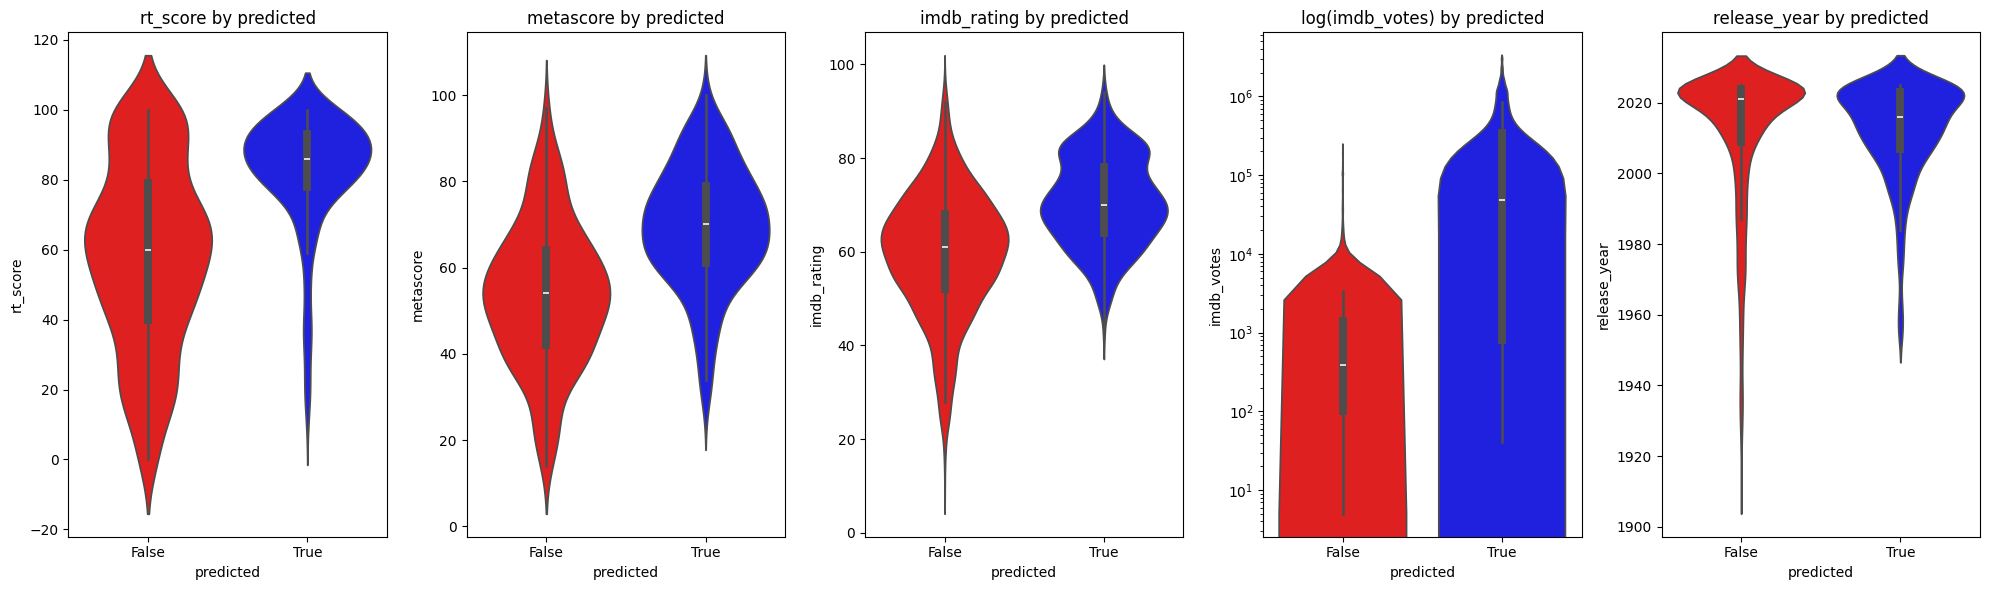

In [21]:
# distribution of numeric values by prediction label

# Create a figure with four subplots side by side
fig, axes = plt.subplots(1, 5, figsize=(20, 6))

# Define the colors for the classes
palette = {False: 'red', True: 'blue'}

# plot
sns.violinplot(x='predicted', y='rt_score', data=pdf, ax=axes[0], hue='predicted', palette=palette)
axes[0].set_title('rt_score by predicted')
axes[0].get_legend().remove()

sns.violinplot(x='predicted', y='metascore', data=pdf, ax=axes[1], hue='predicted', palette=palette)
axes[1].set_title('metascore by predicted')
axes[1].get_legend().remove()

sns.violinplot(x='predicted', y='imdb_rating', data=pdf, ax=axes[2], hue='predicted', palette=palette)
axes[2].set_title('imdb_rating by predicted')
axes[2].get_legend().remove()

sns.violinplot(x='predicted', y='imdb_votes', data=pdf, ax=axes[3], hue='predicted', palette=palette)
axes[3].set_title('log(imdb_votes) by predicted')
axes[3].get_legend().remove()
axes[3].set_yscale('log')

sns.violinplot(x='predicted', y='release_year', data=pdf, ax=axes[4], hue='predicted', palette=palette)
axes[4].set_title('release_year by predicted')
axes[4].get_legend().remove()


# Adjust layout
plt.tight_layout()
plt.show()

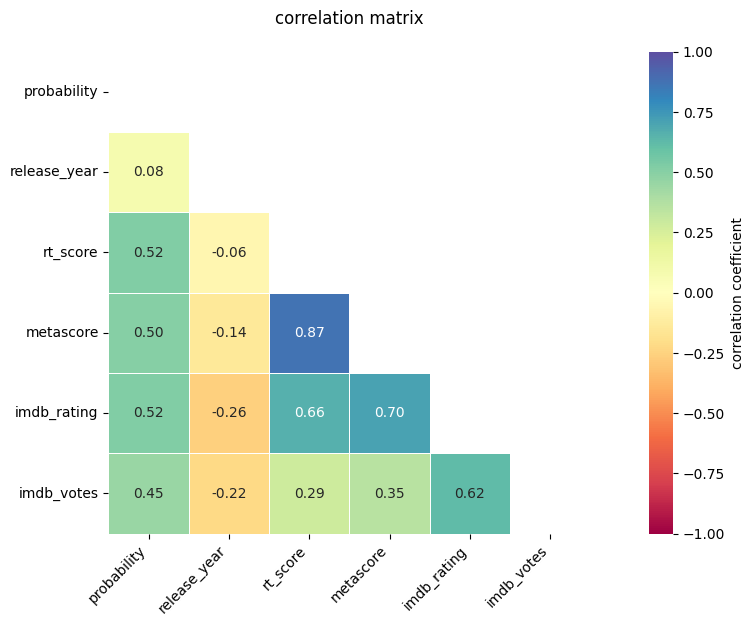

In [22]:
# correlation matrix
corr_df = df.select(
    "probability",
    "release_year",
    "rt_score",
    "metascore",
    "imdb_rating",
    "imdb_votes"
).drop_nulls()

corr_pdf = corr_df.to_pandas()

# Create correlation matrix
corr_matrix = corr_pdf.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# Create heatmap
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,  # Show correlation values
    cmap='Spectral',  # Color scheme
    vmin=-1, vmax=1,  # Value range
    center=0,  # Center the colormap at 0
    square=True,  # Make the plot square-shaped
    fmt='.2f',  # Round correlation values to 2 decimal places
    linewidths=0.5,  # Width of the lines between cells
    cbar_kws={'label': 'correlation coefficient'}
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Add title
plt.title('correlation matrix', pad=20)

# Show the plot
plt.show()

In [23]:
# show outliers
# note: the conditional format will not render in github
false_negatives = df.filter(pl.col("cm_value")=="FN").sort("probability").to_pandas()

# Create styled table with conditional formatting
styled_false_negatives = (false_negatives
    .style
    .background_gradient(subset=['probability'], cmap='RdYlGn_r')  # Red to Yellow to Green (reversed)
    .bar(subset=['probability'], color='#4a90e2', align='mid')  # Add bar charts
    .format({'probability': '{:,.0f}', 'probability': '{:.2f}%'})  # Format numbers
    .set_caption('false positives')
)

display(styled_false_negatives)

false_positives = df.filter(pl.col("cm_value")=="FP").sort("probability", descending=True).to_pandas()

# Create styled table with conditional formatting
styled_false_positives = (false_positives
    .style
    .background_gradient(subset=['probability'], cmap='RdYlGn_r')  # Red to Yellow to Green (reversed)
    .bar(subset=['probability'], color='#4a90e2', align='mid')  # Add bar charts
    .format({'probability': '{:,.0f}', 'probability': '{:.2f}%'})  # Format numbers
    .set_caption('false negatives')
)

display(styled_false_positives)

,media_title,predicted,actual,cm_value,probability,release_year,rt_score,metascore,imdb_rating,imdb_votes,original_title,hash
0,To End All War Oppenheimer The Atomic Bomb,False,True,FN,0.00%,2023,nan,nan,74.000000,2715.000000,To End All War Oppenheimer The Atomic Bomb (2023) [1080p] [WEBRip] [x265] [10bit] [5.1] [YTS.MX],5b3337d18375d7059eb33c5df1a3af45a2c8c277
1,Succubus,False,True,FN,0.00%,2024,nan,nan,46.000000,834.000000,Succubus (2024) [REPACK] [1080p] [WEBRip] [5.1] [YTS.MX],6a368789041c5185ef2b8c7afff540c6797e7dc4
2,Pyaar Ishq Aur Mohabbat,False,True,FN,0.01%,2001,nan,nan,42.000000,700.000000,Pyaar Ishq Aur Mohabbat (2001) [1080p] [WEBRip] [5.1] [YTS.MX],1cf57b5773bd1f0ef6d397b89b5e49d3eefa200d
3,V For Vendetta Unmasked,False,True,FN,0.01%,2006,nan,nan,76.000000,420.000000,V For Vendetta Unmasked (2006) [1080p] [BluRay] [5.1] [YTS.MX],d72bf4ddffc91e692149ac70852cd71c0ac5232a
4,Finding Me,False,True,FN,0.01%,2025,nan,nan,nan,nan,Finding Me (2025) [2160p] [WEBRip] [x265] [10bit] [5.1] [YTS.MX],33d27e3165f8f237f81d4ab393dcf8110e451ac0
5,Matthew Perry: A Hollywood Tragedy,False,True,FN,0.01%,2025,nan,nan,nan,nan,Matthew Perry: A Hollywood Tragedy (2025) [1080p] [WEBRip] [5.1] [YTS.MX],12ba50405d5d170f4c52f90e4c41ad9a8e3e1e89
6,Mickey 17 () [1080p] [WEBRip] [x265] [10bit] [5 1] [YTS MX],False,True,FN,0.01%,2025,nan,nan,nan,nan,Mickey 17 (2025) [1080p] [WEBRip] [x265] [10bit] [5.1] [YTS.MX],209f1161578d097d52df5084652b7e3e7ebe0beb
7,The Twister: Caught in the Storm,False,True,FN,0.01%,2025,nan,nan,nan,nan,The Twister: Caught in the Storm (2025) [1080p] [WEBRip] [5.1] [YTS.MX],9ad8eafe3c6a6da613ec2acceaf93e41a7a6838b
8,Modi: Three Days on the Wing of Madness,False,True,FN,0.04%,2024,nan,nan,nan,65.000000,Modi: Three Days on the Wing of Madness (2024) [720p] [BluRay] [YTS.MX],d2ee39b9ef8fa94778a8decf6317bfb78a65d005
9,Austin Powers Goldmember,False,True,FN,0.08%,2002,nan,nan,nan,nan,Austin Powers - Goldmember (2002) [1080p],7fb68e46f6ce96e3e4e2d5db3e61583c8d66499d


,media_title,predicted,actual,cm_value,probability,release_year,rt_score,metascore,imdb_rating,imdb_votes,original_title,hash
0,Paprika,True,False,FP,0.96%,2006,87,81.000000,77.000000,101403,Paprika (2006) [720p] [BluRay] [YTS.MX],e9740f49b4752f5bdb756c782ba1bfe6349665e1
1,Juror #2,True,False,FP,0.92%,2024,92,72.000000,70.000000,70008,Juror #2 (2024) [1080p] [WEBRip] [5.1] [YTS.MX],7a301b2f48fe976b04921b0205b50a5a9a55b9c8
2,Becoming Led Zeppelin,True,False,FP,0.89%,2025,82,57.000000,nan,43,Becoming Led Zeppelin (2025) [1080p] [WEBRip] [5.1] [YTS.MX],734823429fed3906d1caaef81b666b999165d232
3,The Damned: Don't You Wish That We Were Dead,True,False,FP,0.88%,2015,100,nan,71.000000,475,The Damned: Don't You Wish That We Were Dead (2015) [720p] [BluRay] [YTS.MX],83334cf2e1d5c6a07b6030ed22c2275d98c1d6aa
4,Hollywoodgate,True,False,FP,0.88%,2023,92,nan,72.000000,184,Hollywoodgate (2023) [720p] [WEBRip] [YTS.MX],07b5c11866d66937f05be7af6813918c190c9083
5,Galaxy Quest,True,False,FP,0.86%,1999,90,70.000000,74.000000,183116,Galaxy Quest (1999) [720p] [BluRay] [YTS.MX],bf71bbed16ea112c7b89e91f4e2a16347479c948
6,Eden,True,False,FP,0.86%,2014,84,81.000000,64.000000,5361,Eden (2014) [480p] [BluRay] [YTS.MX],6f90698195d4f9f2aaa554c51a479eadcd9e3c08
7,Nosferatu,True,False,FP,0.84%,2024,85,78.000000,76.000000,89890,Nosferatu (2024) [1080p] [WEBRip] [5.1] [YTS.MX],7a5bc0f7483cb4b7fc0c363f12f5d55a2b614db9
8,Green Border,True,False,FP,0.80%,2023,93,90.000000,64.000000,6769,Green Border (2023) [720p] [BluRay] [YTS.MX],1095d83c25abff481573b2acefa786e443f94f67
9,Matt and Mara,True,False,FP,0.79%,2024,85,nan,nan,102,Matt and Mara (2024) [1080p] [WEBRip] [x265] [10bit] [5.1] [YTS.MX],d6e4ff5258b94aacfa414162d961eab2420dbc27


In [24]:
# export false positives and false negaties for further investigation
false_positives = df.filter(pl.col('cm_value')=="FP").sort("probability")

with open("../data/false_positives.json", "w") as file:
    # Convert to records (list of dicts, each representing a row)
    records = [row for row in false_positives.iter_rows(named=True)]
    json.dump(records, file, indent=4)

false_negatives = df.filter(pl.col('cm_value')=="FN").sort("probability", descending=True)

with open("../data/false_negatives.json", "w") as file:
    # Convert to records (list of dicts, each representing a row)
    records = [row for row in false_negatives.iter_rows(named=True)]
    json.dump(records, file, indent=4)


### issues discoverd with training data

- parsing issue for some titles leading to issues with metadata collection
    - investigate parsing issues
- some items seems to have properly parsed values for media_title, but still have not succesfully collected metadata
    - re-run through OMDB API
